In [1]:
# Step 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Step 3: Load your EEG dataset
import os
import pandas as pd

# Define the directory path using raw string
data_dir = r'C:\Users\wesli\Downloads\Epileptic dataset\csv_files'

# Create an empty list to store the DataFrames
all_data = []

# Iterate over the files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        # Create the full file path
        filepath = os.path.join(data_dir, filename)
        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(filepath)
            # Add a 'Patient_ID' column based on the filename
            # Assuming filenames are like 'Patient_1_data.csv'
            patient_id = filename.split('_')[1]
            df['Patient_ID'] = patient_id
            # Append the DataFrame to the list
            all_data.append(df)
        except pd.errors.EmptyDataError:  # Handle empty files
            print(f"Skipping empty file: {filename}")
        except pd.errors.ParserError:  # Handle parsing errors
            print(f"Error parsing file: {filename}")
        except IndexError: # Handle cases where filename format is unexpected
            print(f"Unexpected filename format: {filename}, skipping Patient_ID assignment.")

# Concatenate all DataFrames into a single DataFrame (if needed)
if all_data:  # Check if any files were read successfully
    combined_df = pd.concat(all_data, ignore_index=True)
    # You can now use combined_df for further analysis
    print("Combined DataFrame shape:", combined_df.shape)
else:
    print("No CSV files found or processed successfully in the directory.")

Combined DataFrame shape: (9418240, 17)


In [3]:
# Step 4: Select only 2 patients and 3000 samples
unique_patients = combined_df['Patient_ID'].unique()
selected_patients = unique_patients[:2]  # First 2 patients
df_2 = combined_df[combined_df['Patient_ID'].isin(selected_patients)].copy()

# Select exactly 3000 samples randomly
df_2 = df_2.sample(n=3000, random_state=42)

print(f"Selected data shape: {df_2.shape}")


Selected data shape: (3000, 17)


In [4]:
# Step 3: Handle missing values (if any)
missing = df_2.isnull().sum().sum()
print(f"Total missing values: {missing}")

# Optionally drop or fill
df_2.dropna(inplace=True)  # or df_2.fillna(method='ffill', inplace=True)


Total missing values: 0


In [5]:
# Step 5: Preprocess (for 2 patients with 3000 samples)
# Ensure df_2 contains only the selected 3000 samples from 2 patients
# If not already sampled:
df_3000 = df_2.sample(n=3000, random_state=42).reset_index(drop=True)

# Check if 'Label' column exists before dropping
if 'Label' in df_3000.columns:
    X = df_3000.drop(columns=['Patient_ID', 'Label'])  # EEG feature matrix
    y = df_3000['Label']  # Target labels
else:
    # Handle case where 'Label' column is not found
    print("Warning: 'Label' column not found. Assuming last column as target.")

    # Assuming the last column is the target and dropping 'Patient_ID'
    X = df_3000.drop(columns=['Patient_ID', df_3000.columns[-1]])
    y = df_3000[df_3000.columns[-1]]

# Normalize EEG features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

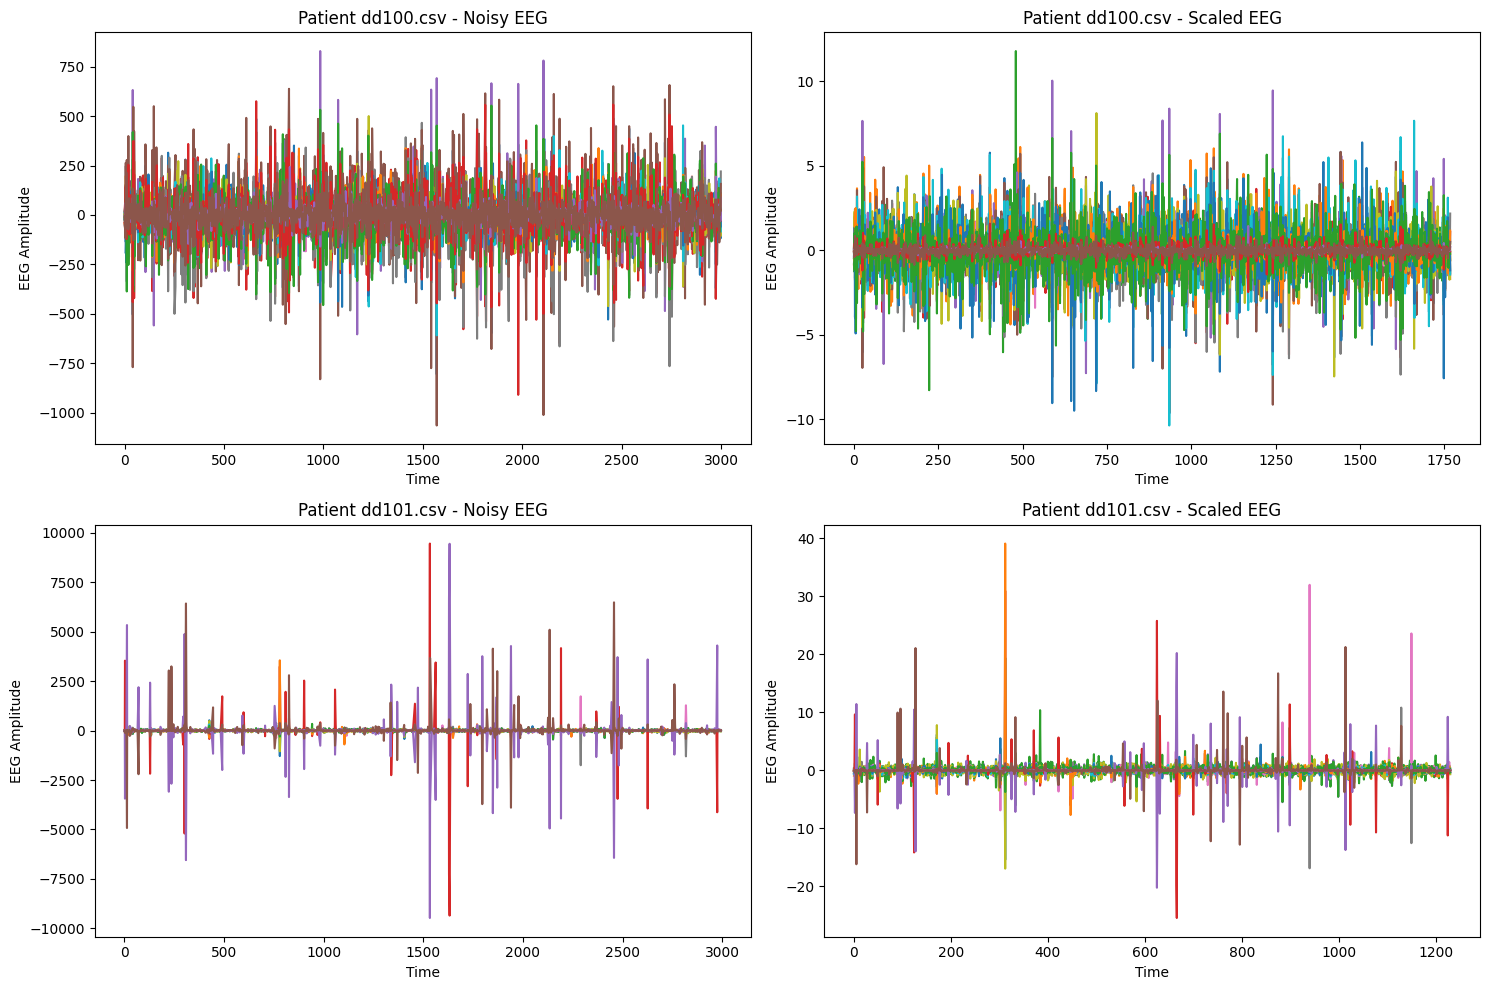

In [6]:
import matplotlib.pyplot as plt

num_patients = 2
fig, axes = plt.subplots(num_patients, 2, figsize=(15, 5 * num_patients))

for i in range(num_patients):
    patient_data = df_3000[df_3000['Patient_ID'] == selected_patients[i]]

    # Safe drop
    columns_to_drop = [col for col in ['Patient_ID', 'Label'] if col in patient_data.columns]
    patient_noisy_data = patient_data.drop(columns=columns_to_drop)

    patient_processed_data = scaler.transform(patient_noisy_data)

    # Plot raw data
    axes[i, 0].plot(patient_noisy_data.index, patient_noisy_data.values)
    axes[i, 0].set_title(f'Patient {selected_patients[i]} - Noisy EEG')

    # Plot scaled data
    axes[i, 1].plot(range(len(patient_processed_data)), patient_processed_data)
    axes[i, 1].set_title(f'Patient {selected_patients[i]} - Scaled EEG')

    for ax in axes[i]:
        ax.set_xlabel("Time")
        ax.set_ylabel("EEG Amplitude")

plt.tight_layout()
plt.show()


In [7]:
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [8]:
# Step 7: Train the SVM model
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train, y_train)
# Step 8: Predict and evaluate
y_pred = svm.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("SVM Model Score:", svm.score(X_test, y_test))

Confusion Matrix:
 [[268  87]
 [ 31 214]]

Classification Report:
               precision    recall  f1-score   support

   dd100.csv       0.90      0.75      0.82       355
   dd101.csv       0.71      0.87      0.78       245

    accuracy                           0.80       600
   macro avg       0.80      0.81      0.80       600
weighted avg       0.82      0.80      0.80       600

SVM Model Score: 0.8033333333333333


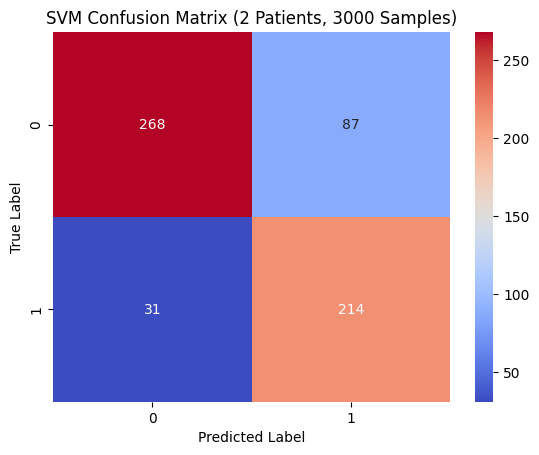

In [9]:
# Step 9: Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix (2 Patients, 3000 Samples)')
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001], # Kernel coefficient
    'kernel': ['rbf', 'linear'] # Kernel type
}

# Create a GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_}")

# Evaluate the best model on the test set
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Best SVM Model Score:", best_svm.score(X_test, y_test))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.802 total time=   0.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.806 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.796 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.810 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.783 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.588 total time=   0.7s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.596 total time=   0.7s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.594 total time=   0.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.596 total time=   0.4s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.592 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

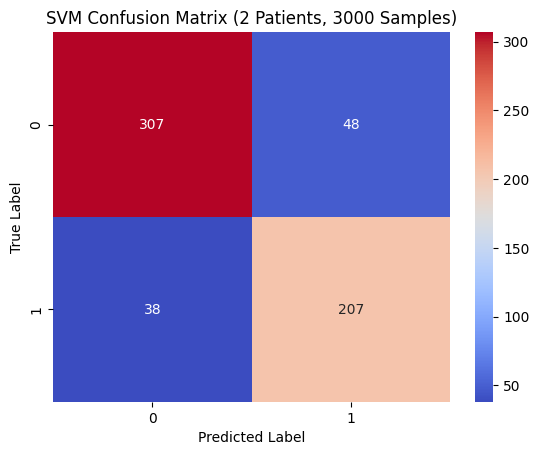

In [11]:

# Assuming 'y_test' and 'y_pred' are already defined from your SVM model

# Step 9: Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix (2 Patients, 3000 Samples)')
plt.show()
